In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.callbacks import ProgbarLogger, TensorBoard, LambdaCallback

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime
from io import StringIO

print(tf.__version__)

Using TensorFlow backend.


2.0.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

In [3]:
img_rows, img_cols = (28, 28)
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
half_validate = round(test_images.shape[0] / 2)

In [4]:
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [11]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

In [12]:
def get_model_dense():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model
def get_model_dense2():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model
def get_model_dense3():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(400, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [7]:
def get_model_basic_conv():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [8]:
def get_model_basic_conv2():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [110]:
def get_model_basic_conv3():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.Dense(400, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [111]:
def get_model_basic_rand():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu', trainable=False),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [112]:
def get_model_basic_rand2():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
        keras.layers.Flatten(),
        keras.layers.Dense(1280, activation='relu', trainable=False),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [113]:
def get_model_basic_rand3():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
        keras.layers.Flatten(),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [23]:
train_images[0].shape[0]

28

In [47]:
train_images.shape

(60000, 28, 28, 1)

In [171]:
models = [
    [("dense", get_model_dense()), ("dense2", get_model_dense2()), ("dense3", get_model_dense3())],
    [("conv", get_model_basic_conv()), ("conv2", get_model_basic_conv2()), ("conv3", get_model_basic_conv3())],
    [("rand", get_model_basic_rand()), ("rand2", get_model_basic_rand2()), ("rand3", get_model_basic_rand3())]
]

In [172]:
for model_type in models:
    for _, model in model_type:
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

In [173]:
date_of_training = datetime.datetime.now().strftime("%Y%m%d-%H%M%S");
for model_type in models:
    for name, model in model_type:
        log_dir="logs/fit/" + name + "/" + date_of_training
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        model.fit(
            train_images,
            train_labels,
            epochs=100,
            shuffle=True,
            validation_data=(test_images[:half_validate], test_labels[:half_validate]),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=5,
                    restore_best_weights=True,
                ),
                tensorboard_callback
            ]
        )   

Train on 60000 samples, validate on 5000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 104us/sample - loss: 0.5008 - accuracy: 0.8243 - val_loss: 0.4392 - val_accuracy: 0.8404
Epoch 2/100
60000/60000 [==============================] - 5s 90us/sample - loss: 0.3756 - accuracy: 0.8642 - val_loss: 0.3950 - val_accuracy: 0.8534
Epoch 3/100
60000/60000 [==============================] - 5s 85us/sample - loss: 0.3370 - accuracy: 0.8779 - val_loss: 0.3907 - val_accuracy: 0.8610
Epoch 4/100
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3114 - accuracy: 0.8857 - val_loss: 0.3537 - val_accuracy: 0.8726
Epoch 5/100
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2955 - accuracy: 0.8909 - val_loss: 0.3627 - val_accuracy: 0.8640
Epoch 6/100
60000/60000 [==============================] - 4s 74us/sample - loss: 0.2802 - accuracy: 0.8954 - val_loss: 0.3409 - val_accuracy: 0.8788
Epoch 7/100
60000/60000 [=======================

Epoch 1/100
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.7949 - accuracy: 0.7114 - val_loss: 0.6264 - val_accuracy: 0.7654
Epoch 2/100
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.5587 - accuracy: 0.7955 - val_loss: 0.5628 - val_accuracy: 0.7944
Epoch 3/100
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.5157 - accuracy: 0.8144 - val_loss: 0.5139 - val_accuracy: 0.8190
Epoch 4/100
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.4892 - accuracy: 0.8257 - val_loss: 0.5255 - val_accuracy: 0.8124
Epoch 5/100
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.4727 - accuracy: 0.8318 - val_loss: 0.4756 - val_accuracy: 0.8310
Epoch 6/100
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.4604 - accuracy: 0.8356 - val_loss: 0.5098 - val_accuracy: 0.8158
Epoch 7/100
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.4482 - accuracy:

In [174]:
results = [
    [
        model.evaluate(
            test_images[half_validate:],
            test_labels[half_validate:],
            verbose=0,
        ) for _, model in model_type
    ] for model_type in models
]

In [175]:
results = [[idx2[1] for idx2 in idx] for idx in results]

In [176]:
results = np.array(results)

In [181]:
results

array([[0.8828, 0.8398, 0.8946],
       [0.9052, 0.903 , 0.9102],
       [0.8762, 0.899 , 0.8548]], dtype=float32)

In [183]:
with open("output/resultMnist.output", 'w+') as file:
    file.writelines([str(results.shape).lstrip("(").rstrip(")") + "\n"])
    np.savetxt(file, results.reshape(-1, 1))

In [9]:
file = open("output/resultMnist.output", "r")
shape = tuple(map(int, file.readline().rstrip().split(",")))
dim_of_interest = 0
data = np.genfromtxt(StringIO(file.read()))
data = data.reshape(shape)

In [12]:
dimension_meaning = ["", "", "", ""]
values = [
    ["Dense", "Conv", "Random layers"],
    ["11"]
]

In [21]:
import sys, os
sys.path.append(os.path.abspath("../../plots/"))
import plotter

<module 'plotter' from '/Users/msladek/Documents/eth/deeplearning/deep-learning-course/code/plots/plotter.py'>

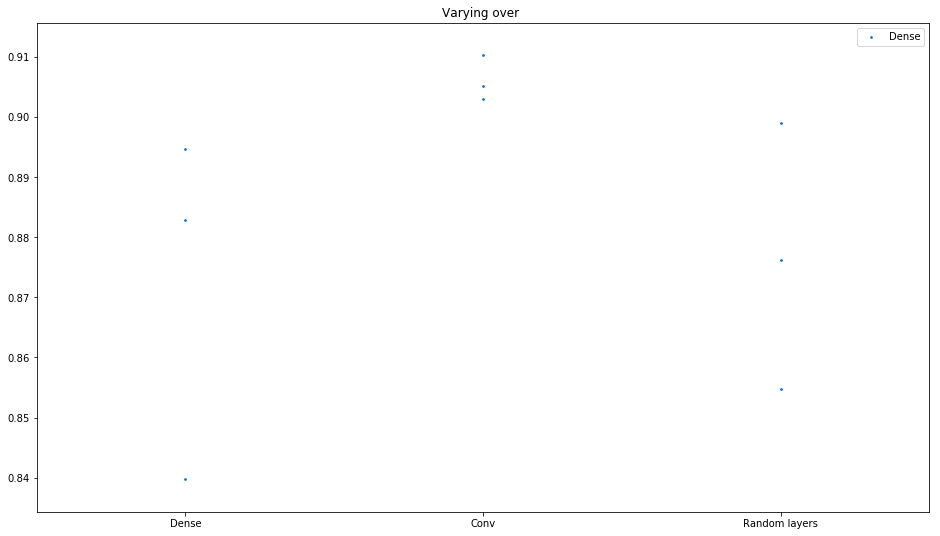

In [22]:
plotter.plot_marginals(
    data,
    dimension_meaning,
    values,
    0
)